In [3]:
import csv
import pandas as pd


def filter_cells_mean(cells):
    essids = {essid for essid, _ in cells}
    signals = {essid: [s for e, s in cells if e == essid] for essid in essids}
    return {essid: sum(signals[essid]) / len(signals[essid]) for essid in signals}


def reduce_labels(labels, essids):
    signals = {essid: [] for essid in essids}

    for label in labels:
        for record in labels[label]:
            for essid in record:
                signals[essid].append((label, record[essid]))

    max_signals = max([len(signals[essid]) for essid in signals])
    return {e: signals[e] for e in signals if len(signals[e]) == max_signals}


def build_dataset():

    rows = []
    with open("smartlab.csv") as data:
        rows += csv.reader(data, delimiter=",")

    labels = {row[0]: [] for row in rows}
    essids = set()

    for row in rows:
        cells = [(row[i], float(row[i + 1])) for i in range(1, len(row), 2)]
        cells = filter_cells_mean(cells)
        essids.update(cells)
        labels[row[0]].append(cells)

    cells = reduce_labels(labels, essids)
    return cells, list(cells)


def explode(cells, essids):
    labels = [label for label, _ in cells[essids[0]]]
    cells = {essid: [signal for _, signal in cells[essid]] for essid in cells}
    return pd.DataFrame(dict(**cells, label=labels))


dataset, essids = build_dataset()
ds = explode(dataset, essids)

ds.head()

,itis-wifi,Bassi,AP_ITISLI03_5.0,wifi-lab01,AP_SMART50,AP_SMART25,Ollare the phone,label
0,-79.500000,-64.0,-64.0,-79.5,-62.0,-54.0,-68.0,b
1,-79.666667,-69.0,-69.0,-77.0,-58.0,-60.0,-68.0,b
2,-79.666667,-65.0,-68.0,-77.0,-52.0,-60.0,-72.0,b
3,-80.000000,-61.0,-68.0,-73.0,-57.0,-65.0,-73.0,b
4,-81.000000,-58.0,-63.0,-75.0,-47.0,-65.0,-71.0,b


In [8]:
from sklearn.model_selection import train_test_split

x = ds[essids]
y = ds["label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

In [15]:
from sklearn import metrics

accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy

0.7222222222222222

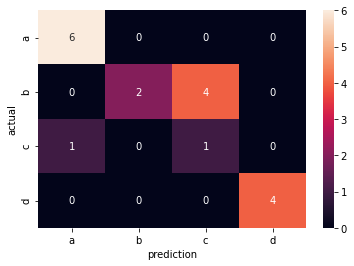

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.heatmap(
    pd.crosstab(
        y_test,
        y_pred,
        rownames=["actual"],
        colnames=["prediction"],
    ),
    annot=True,
)

plt.show()